### This is to make a map figure that shows the intrusions of mCDW in Antarctica and highlights our region of study in the context of East Antarctica.
#### It requires the XXXLarge core (the largest plus memory increment)

#### Here we will have: 
##### - t400m inside the 1000m isobath
##### - Bottom temperature inside the 1000m isobath (could only make one year only because it is very heavy. I chose 2012 because it is the year where we have more obs)
##### - Obs version inside the 1000m isobath 



### IMPORT PACKAGES

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
import matplotlib.colors as mcolors
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


<Client: 'tcp://127.0.0.1:32937' processes=7 threads=28, memory=251.19 GiB>

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### LOAD DATA SETS

### 1. Load temperature from IAF at determined depth

In [4]:
# load temperature data at 400m:

depth_slice = 400
# this was working before I made the test below
#lat_slice  = slice(-75.5,-62)
lon_slice  = slice(-275, -200)
lat_slice  = slice(-75.5,-62)
#lon_slice  = slice(-359, -180)


temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

In [5]:
#average for temperature 
temp_400m_avg = temp_400m.mean('time')

In [6]:
# load temperature data at 1000m:

depth_slice = 1000
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-50)
#lon_slice  = slice(-275, -200)

temp_1000m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_1000m = temp_1000m.sel(yt_ocean=lat_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_1000m = temp_1000m.load()

In [7]:
#average for temperature 
temp_1000m_avg = temp_1000m.mean('time')

### 2. Load IAF temperature from 2012 and calculate bottom temperature (struggling to add more)

In [8]:
## too heavy for memmory, couldn't do for the whole cycle. Maybe try choosing just the last 10 years of data.
first_year = '2012'
last_year = '2012'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

##load bottom temperature
lat_slice  = slice(-75.5,-62)
lon_slice  = slice(-275, -200)

temp_bt= cc.querying.getvar(iaf_cycle3,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15

# select out bottom temperature values:
depth_array = temp_bt*0 + temp_bt.st_ocean
# find bottom grid cell at each lat/lon:
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
# select out bottom values:
bottom_temp_cycle3 = temp_bt.where(depth_array.st_ocean >= max_depth)
bottom_temp_cycle3 = bottom_temp_cycle3.sum(dim = 'st_ocean')


In [9]:
#load data
bottom_temp_cycle3 = bottom_temp_cycle3.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

In [10]:
#average for bottom temperature
bottom_temp_cycle3_avg = bottom_temp_cycle3.mean('time')

### LOAD SEAL DATA

### I am not sure how exactly I got this all to work. However, if I want to try to expand the domain, this is the logic I have gone by using other routines that were working as base:
##### Fig1_new       / Fig2a-b
##### Bathymetry
##### - -275; -200  / -255; -247
##### - -75.5; -62  / -75.5; -60
#####
##### Model grid 
##### - same as above / same as above
#####
##### Seals (+360 on lon values)
##### 85; 160  / 104; 114     
#####
##### Maybe try to compare to the Validation_figure next time if trying to expand this domain a bit more. 
##### Another thing to try is to plot without binning just to see what we manage to load. Then, if it loads alright, we could bin it. Maybe will need to create a new notebook for that.

In [12]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

#lon_slice  = slice(-359, -180)
lon_slice  = slice(-275, -200)
lat_slice  = slice(-75.5,-62)

In [13]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [14]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

In [15]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

#### Select out profiles in correct region (East Antarctica)

In [16]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/jk72/ns3783/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in East Antarctic Peninsula box:
    WAP_box=lat.where(lon>84).where(lon<160).where(lat<-62).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 24.3 s, sys: 4.72 s, total: 29 s
Wall time: 1min 20s


In [17]:
np.shape(WAP_FileList)

(152,)

In [19]:
# testing to figure out how many profiles we have to run in the next cell
np.size(profile_data.TEMP_ADJUSTED)

8056

In [20]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:
# actually I am not sure if this code selects the profiles on the shelf, I don't think it does. 

nprofiles = 152000 # tested with one run / so this is all good. I know this is the right number for this dataset (152 x 1000)
ndepth = 1000 #although I have downloaded the profiles with no interpolation, some might have been interpolated because it doesn't run with less than 1000 levels
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
sal = np.zeros((nprofiles,ndepth))

temp_0 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_0 = np.zeros((nprofiles,1))
temp_100 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_100 = np.zeros((nprofiles,1))
temp_300 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_300 = np.zeros((nprofiles,1))
temp_500 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_500 = np.zeros((nprofiles,1))

sal_0 = np.zeros((nprofiles,1)) 
sal_100 = np.zeros((nprofiles,1)) 
sal_300 = np.zeros((nprofiles,1)) 
sal_500 = np.zeros((nprofiles,1)) 

lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
#date_obs = np.zeros((nprofiles)) 
year_obs = np.zeros((nprofiles))
month_obs = np.zeros((nprofiles))

profile_count = 0

for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    juld = profile_data.JULD
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        temp_profile = profile_data.TEMP_ADJUSTED[profile]
        sal_profile = profile_data.PSAL_ADJUSTED[profile]
        if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
            # check the dive reached at least 200 dbar:
            pres_profile = profile_data.PRES_ADJUSTED[profile]
            if pres_profile.max() > 200:
                date = np.append(date,profile_data.JULD[profile])
                #date_obs[profile_count] = date[profile]
                year_obs[profile_count] = profile_data.JULD[profile].dt.year #this is an add on to lock months and years separately
                month_obs[profile_count] = profile_data.JULD[profile].dt.month
                # save profile:
                lat_obs[profile_count] = lat[profile]
                lon_obs[profile_count] = lon[profile]
                # find depth of profile:
                nlevels = len(profile_data.PRES_ADJUSTED[profile])
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                sal[profile_count,:nlevels] = sal_profile
               
                profile_count += 1

CPU times: user 6min 10s, sys: 29.6 s, total: 6min 39s
Wall time: 6min 16s


In [21]:
np.size(temp)

152000000

## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [22]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(sal,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [23]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [24]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [25]:
np.unique(year_obs)

array([   0., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.])

In [26]:
nprofiles

152000

### Interpolating the seal data to the model grid. >> this is working know, but I am not sure what exactly I have done that got it right. Maybe you have to have the exact grid size


In [27]:
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles,50))

for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_profile = pres[profile,:][pres[profile,:]>0]

In [28]:
pres

array([[ 4., 10., 20., ...,  0.,  0.,  0.],
       [ 4., 10., 20., ...,  0.,  0.,  0.],
       [ 4., 10., 20., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [29]:
nprofiles

152000

In [30]:
print(pres.shape)

(152000, 1000)


In [31]:
%%time
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles, 50))
valid_profile_counter = 0  # Counter for valid profiles
for profile in range(nprofiles):
     # Extract the profile
    pres_profile = pres[profile, :]
    temp_profile = temp_conservative[profile,:]
    # Skip profiles that contain only zeros
    if np.all(pres_profile == 0):
        #print(f"Skipping profile {profile} because it contains only zeros")
        continue

    # Select out available pressure range of data
    pres_profile = pres_profile[pres_profile > 0]
    temp_profile = temp_profile[pres[profile,:]>0]
    # also remove missing temperature points:
    temp_profile_adj = temp_profile[temp_profile!=0]
    pres_profile_adj = pres_profile[temp_profile!=0]

    f = interpolate.interp1d(pres_profile,temp_profile,bounds_error=False)
    temp_interp[profile,:] = f(st_ocean)

CPU times: user 16.9 s, sys: 1.56 s, total: 18.5 s
Wall time: 17 s


In [32]:
temp_interp.shape

(152000, 50)

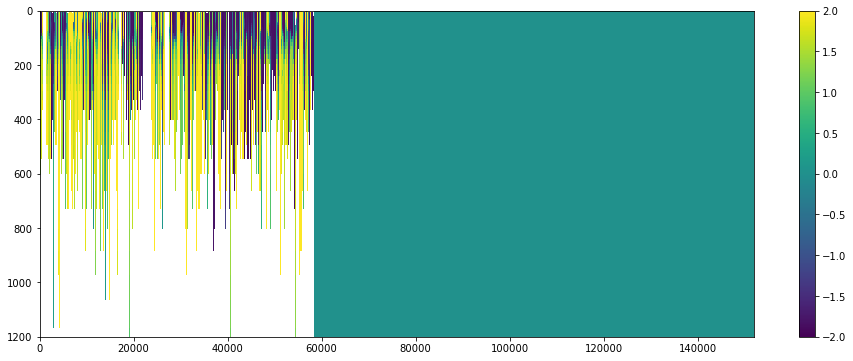

In [33]:
# check profiles look ok:
x_2d,y_2d = np.meshgrid(np.arange(nprofiles),st_ocean)

plt.figure(figsize=(16,6))
plt.pcolormesh(x_2d,y_2d,temp_interp.swapaxes(0,1))
plt.ylim(1200,0)
plt.colorbar()
plt.clim(-2,2)

### saving data

In [38]:
temp_interp = xr.DataArray(temp_interp, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'seal profiles interpolated onto model depth grid')
lon_obs = xr.DataArray(lon_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs = xr.DataArray(lat_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of seal profiles')
month_obs = xr.DataArray(month_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'month of seal profiles')
year_obs = xr.DataArray(year_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'year of seal profiles')
#date = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

ds = xr.Dataset({'temp_interp': temp_interp,'lon_obs':lon_obs,'lat_obs':lat_obs,'month_obs':month_obs,'year_obs':year_obs})
outpath = '/g/data/v45/ns3783/EA_MEOP_profiles_interpolated_conserv1.nc'
ds.to_netcdf(outpath)

## Open saved seal data:

In [39]:
outpath = '/g/data/v45/ns3783/EA_MEOP_profiles_interpolated_conserv1.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
month_obs = profile_data.month_obs
year_obs = profile_data.year_obs
temp_interp = profile_data.temp_interp

# need to assign lat/lon coords for binning:
temp_interp = temp_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})

In [43]:
np.unique(year_obs)

array([   0., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.])

## PLOT T & SALT to see if all is good

Text(0.5, 0, 'Longitude')

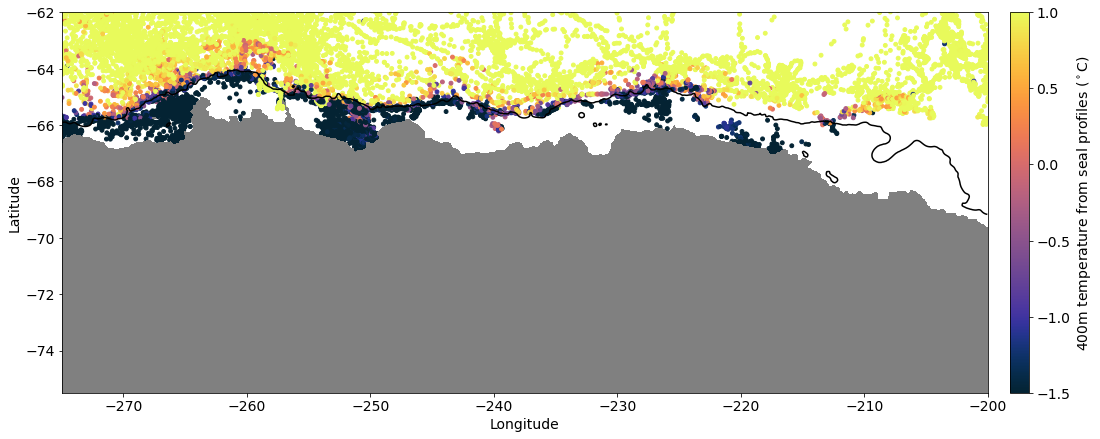

In [55]:
# plot 200m slice:
fontsize = 14
depth_slice = 400

plt.figure(figsize=(20,7))
sc = plt.scatter(lon_obs-360,lat_obs,c=temp_interp.sel(st_ocean=depth_slice,method='nearest'),s=15,cmap=cmocean.thermal,vmin=-1.5,vmax=1)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-75.5, -62))
plt.xlim((-275, -200))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)


## Bin seal data into lat/lon bins:
### that is because they are a bit on top of one another and my attempt at sortng failed.

In [44]:
# set up new bins:
lon_bins = np.arange(84, 160, .1)
lat_bins = np.arange(-76, -62, .1) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# just do for a single depth slice:
depth = 400
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')


lon bin 0/759
lon bin 1/759
lon bin 2/759
lon bin 3/759
lon bin 4/759
lon bin 5/759
lon bin 6/759
lon bin 7/759
lon bin 8/759
lon bin 9/759
lon bin 10/759
lon bin 11/759
lon bin 12/759
lon bin 13/759
lon bin 14/759
lon bin 15/759
lon bin 16/759
lon bin 17/759
lon bin 18/759
lon bin 19/759
lon bin 20/759
lon bin 21/759
lon bin 22/759
lon bin 23/759
lon bin 24/759
lon bin 25/759
lon bin 26/759
lon bin 27/759
lon bin 28/759
lon bin 29/759
lon bin 30/759
lon bin 31/759
lon bin 32/759
lon bin 33/759
lon bin 34/759
lon bin 35/759
lon bin 36/759
lon bin 37/759
lon bin 38/759
lon bin 39/759
lon bin 40/759
lon bin 41/759
lon bin 42/759
lon bin 43/759
lon bin 44/759
lon bin 45/759
lon bin 46/759
lon bin 47/759
lon bin 48/759
lon bin 49/759
lon bin 50/759
lon bin 51/759
lon bin 52/759
lon bin 53/759
lon bin 54/759
lon bin 55/759
lon bin 56/759
lon bin 57/759
lon bin 58/759
lon bin 59/759
lon bin 60/759
lon bin 61/759
lon bin 62/759
lon bin 63/759
lon bin 64/759
lon bin 65/759
lon bin 66/759
lon b

## PLOT of BINNED TEMP

Text(0.5, 0, 'Longitude')

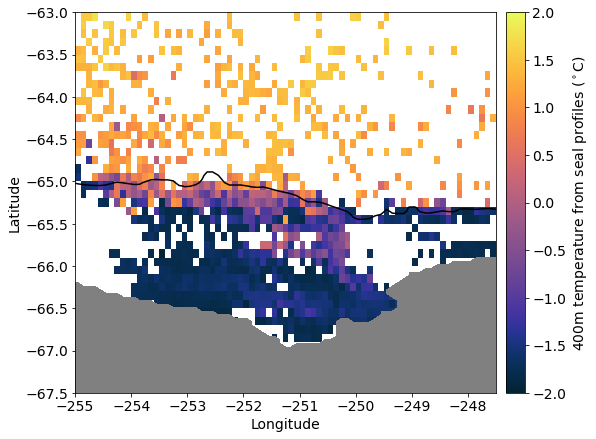

In [82]:
# plot 200m slice:
fontsize = 14
depth_slice = 400

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
sc=plt.pcolormesh(binned_meop_temp.lon_bin-360,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)


## Cut onshore mask 

In [11]:
# cut the data BOX 1
#lon_slice  = slice(-275,-200)
lat_slice  = slice(-75.5,-50)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

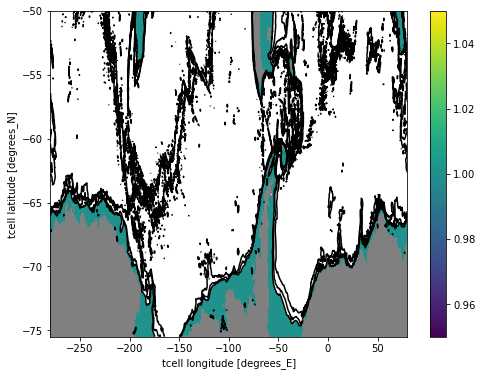

In [12]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/v45/ns3783/scripts/masks/Fig1_mask1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [13]:
#apply the mask
temp_400m_off = temp_400m_avg*region_mask
temp_400m_off = temp_400m_off.where(temp_400m_off!=0)

In [14]:
# first time step only:
temp_400m_avg

<xarray.DataArray 'temp' (yt_ocean: 316, xt_ocean: 3600)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [2.3294332, 2.3153975, 2.3063223, ..., 2.3982673, 2.3734953,
        2.3494413],
       [2.3228016, 2.311127 , 2.3046963, ..., 2.3830996, 2.3607125,
        2.3394477],
       [2.3178024, 2.3087342, 2.3038652, ..., 2.3700044, 2.3498743,
        2.3316538]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -75.49 -75.45 -75.41 ... -62.13 -62.08 -62.03
    st_ocean  float64 383.0

In [15]:
## too heavy for model, couldn't load the data. 
#apply the mask to bottom temperature
bottom_temp_cycle3_off = bottom_temp_cycle3_avg*region_mask
bottom_temp_cycle3_off = bottom_temp_cycle3_off.where(bottom_temp_cycle3_off!=0)

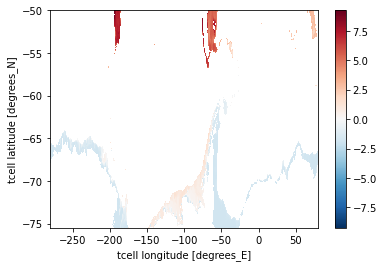

In [16]:
# first time step only:
bottom_temp_cycle3_off.plot()

## Cut offshore mask 

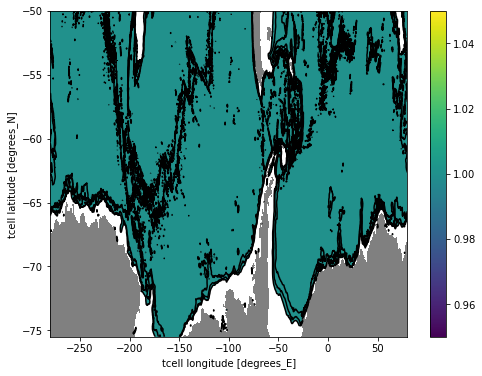

In [17]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/v45/ns3783/scripts/masks/Fig1_mask1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [18]:
#apply the mask
temp_1000m_off = temp_1000m_avg*region_mask
temp_1000m_off = temp_1000m_off.where(temp_1000m_off!=0)

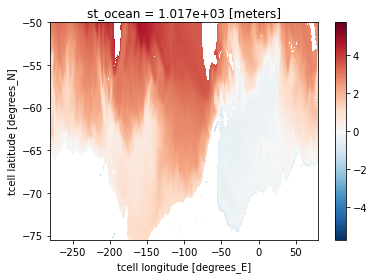

In [19]:
# first time step only:
temp_1000m_off.plot()

## Rename obs binned data coordinates and correct lon values

In [106]:
# Subtract 360 from both lat_bin and lon_bin values so I can cut them using the model mask
binned_meop_temp_renamed = binned_meop_temp.assign_coords({
    "lat_bin": binned_meop_temp.coords["lat_bin"],
    "lon_bin": binned_meop_temp.coords["lon_bin"] - 360
})

In [107]:
#I have to rename the coordinates in binned_meop_temp to be able to cut it successfully:
# Rename the dimensions
binned_meop_temp_renamed = binned_meop_temp_renamed.rename({"lat_bin": "yt_ocean", "lon_bin": "xt_ocean"})

# Check the result
print(binned_meop_temp_renamed)

<xarray.DataArray 'binned meop temperature data' (yt_ocean: 139, xt_ocean: 759)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 1.96419476, ...,        nan,        nan,
               nan]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -75.95 -75.85 -75.75 ... -62.35 -62.25 -62.15
  * xt_ocean  (xt_ocean) float64 -275.9 -275.9 -275.8 ... -200.4 -200.3 -200.2


### PLOT MAP v1: IAF temp at 400m in the continental shelf and at 1000m offshore

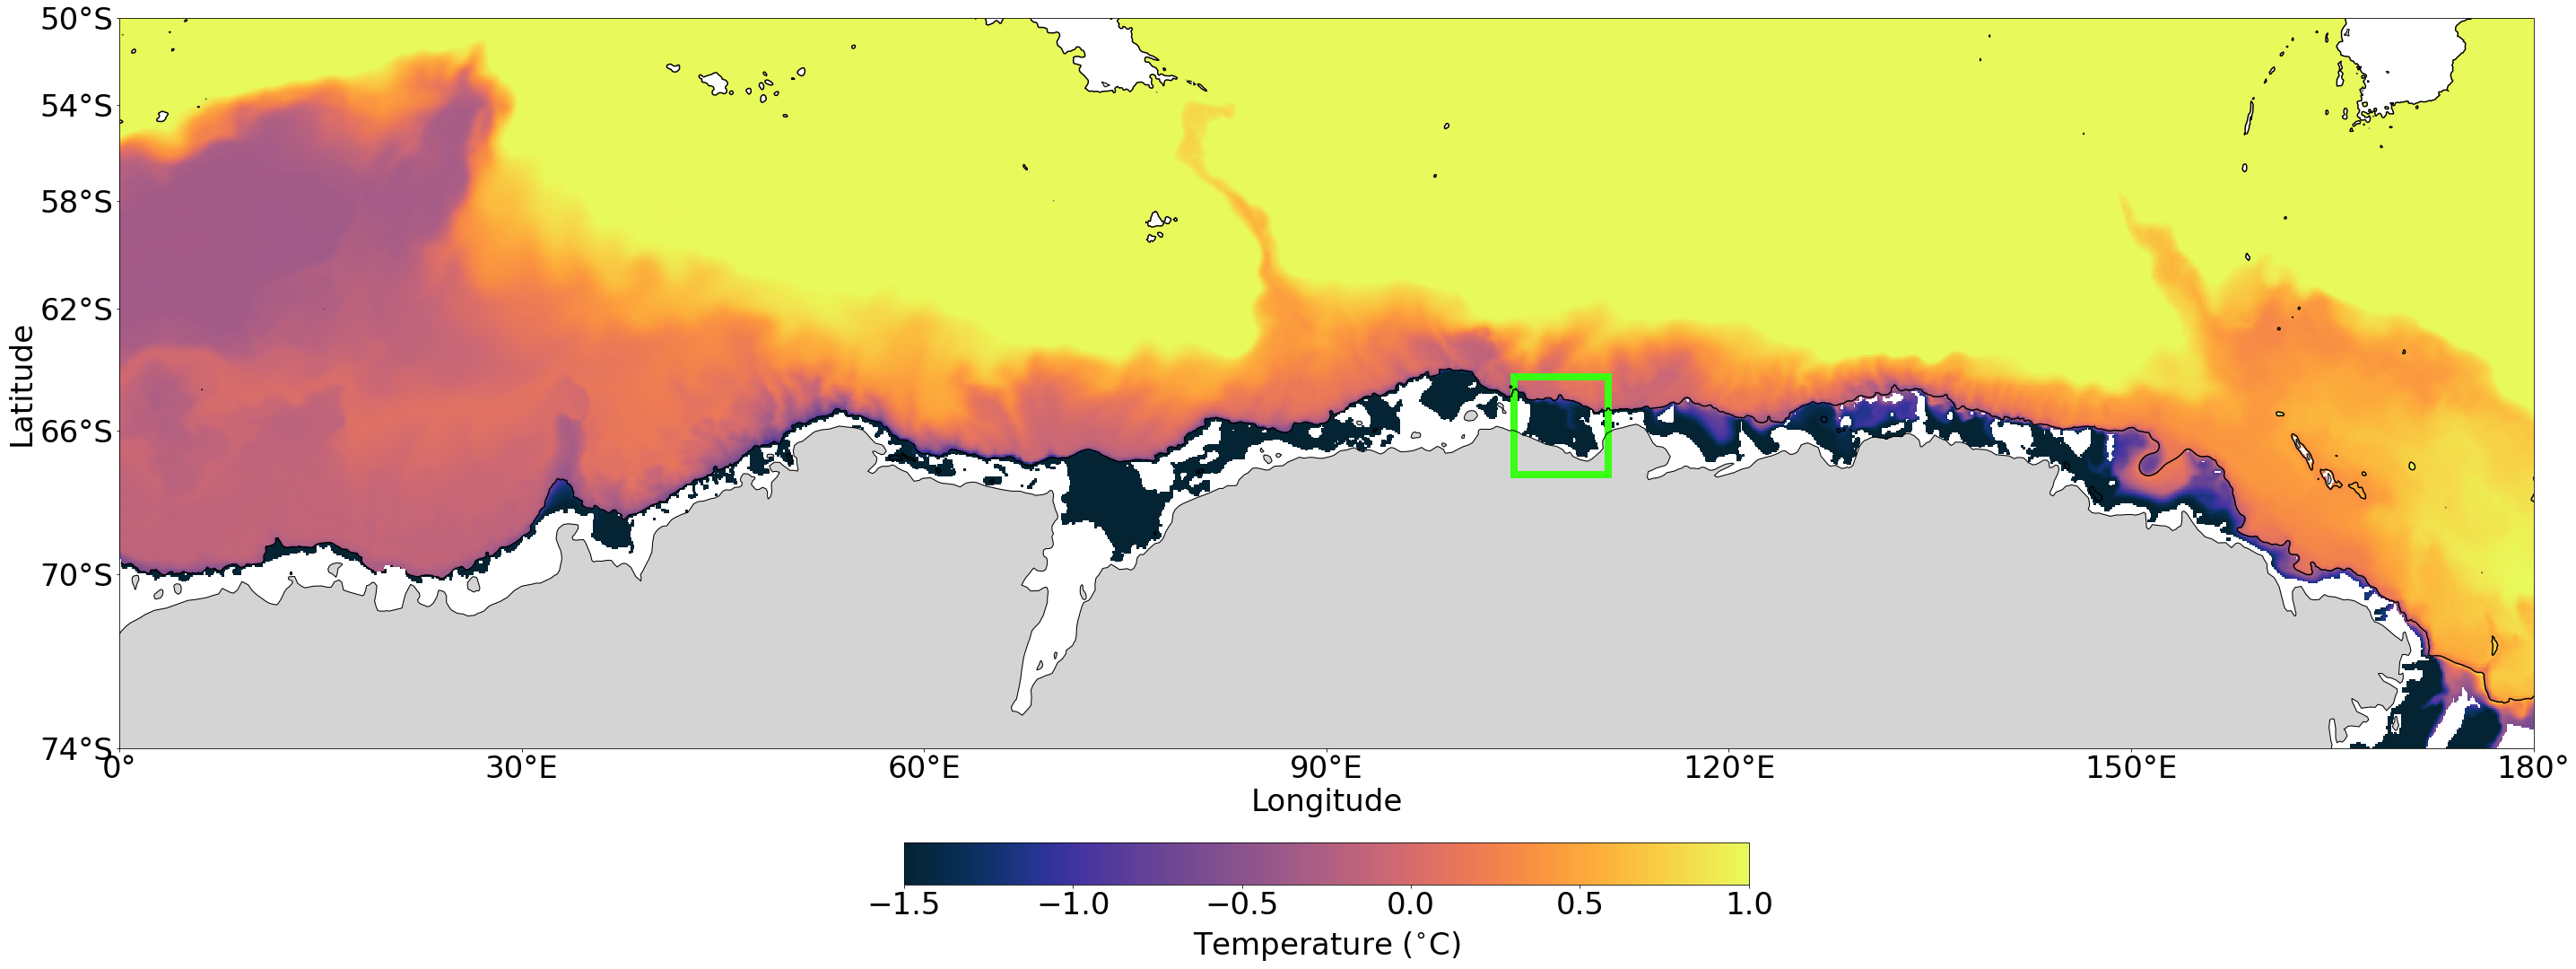

In [28]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
#cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
#cbar.ax.tick_params(labelsize=20)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add colorbar below the plot horizontally
cbar = fig.colorbar(pc, ax=ax, shrink=0.35, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature ($^{\circ}$C)', fontsize=fontsize, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_horizontal_cbar_T400.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

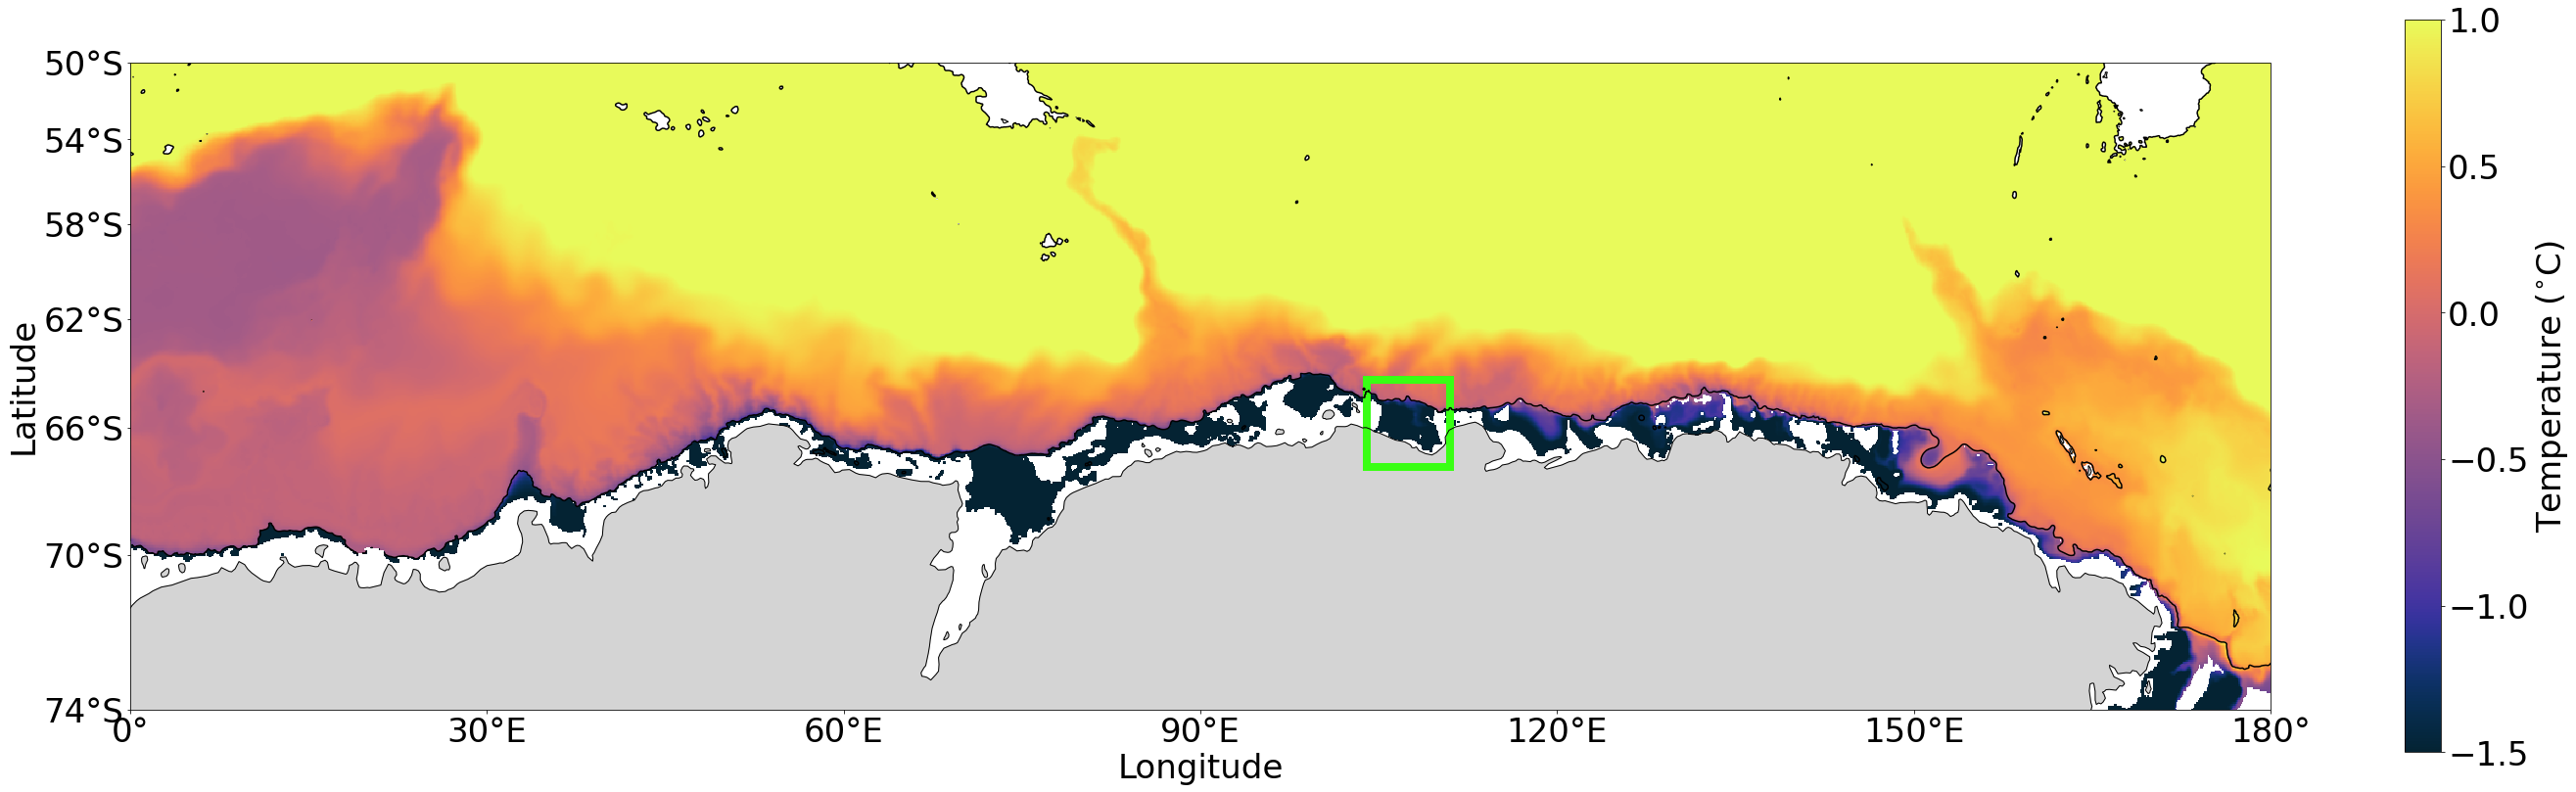

In [29]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature ($^{\circ}$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_vertical_cbar_T400.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### PLOT MAP v2: IAF bottom temp in the continental shelf and at 1000m  I chose the year of 2012, because it is when we have more seal data to compare the model to. 

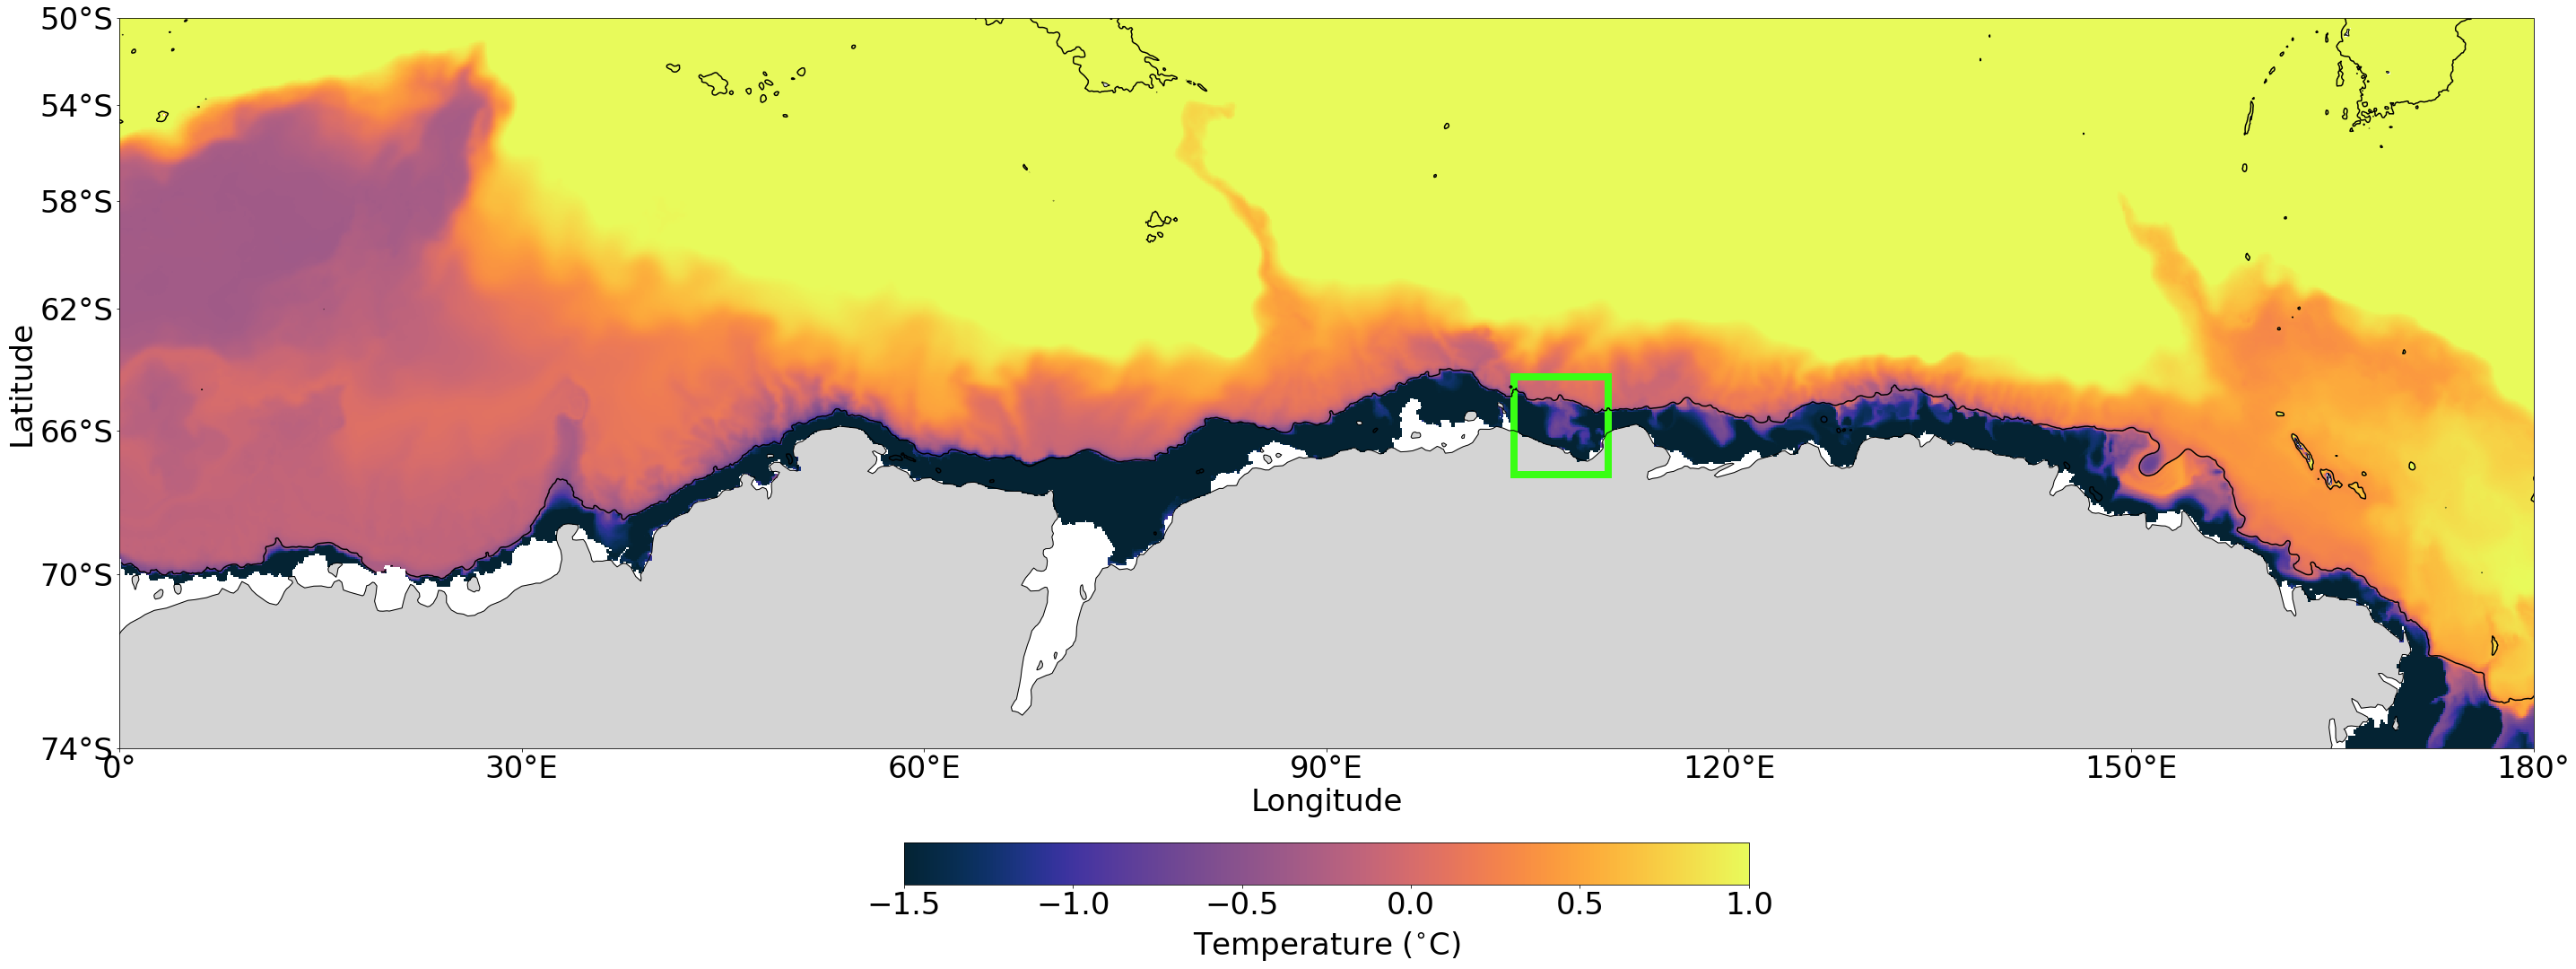

In [30]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(bottom_temp_cycle3_off.xt_ocean,bottom_temp_cycle3_off.yt_ocean,
                        bottom_temp_cycle3_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
#cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
#cbar.ax.tick_params(labelsize=20)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add colorbar below the plot horizontally
cbar = fig.colorbar(pc, ax=ax, shrink=0.35, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature ($^{\circ}$C)', fontsize=fontsize, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_horizontal_cbar_bt.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

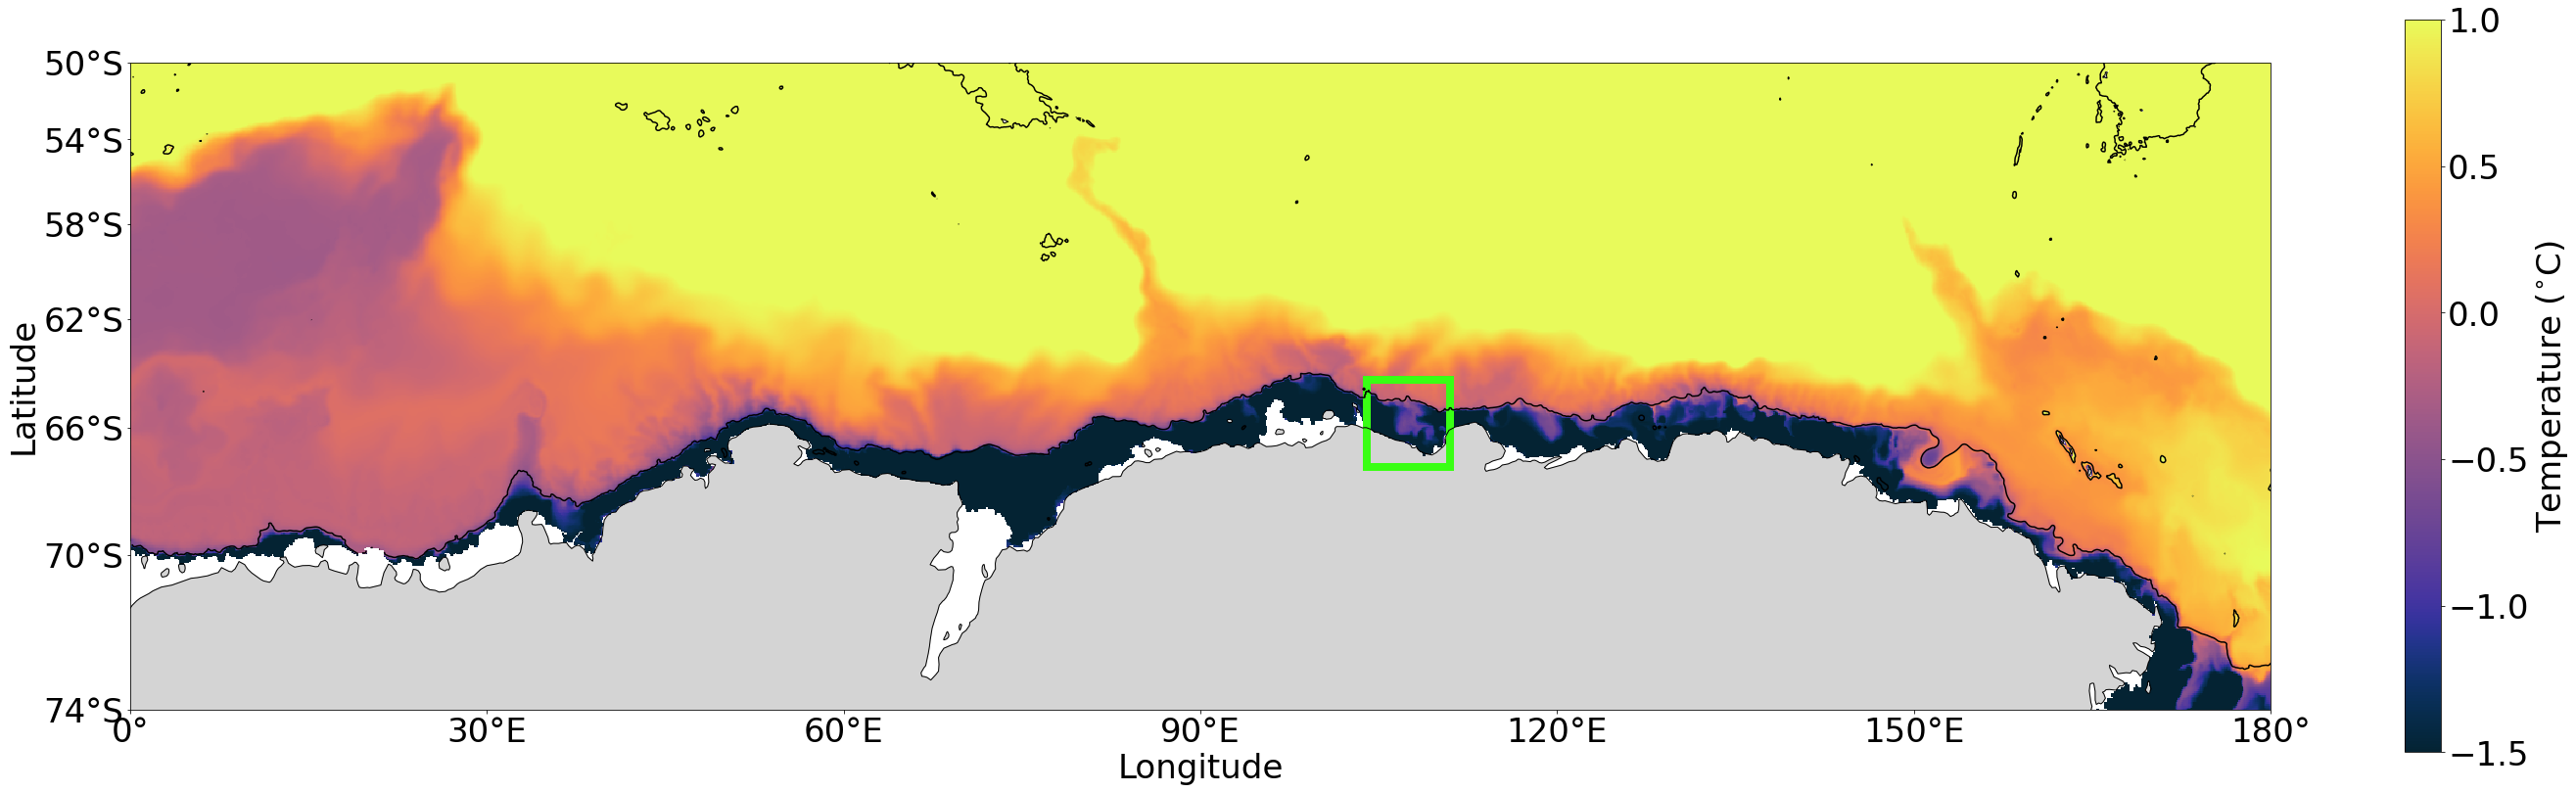

In [31]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(bottom_temp_cycle3_off.xt_ocean,bottom_temp_cycle3_off.yt_ocean,
                        bottom_temp_cycle3_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature ($^{\circ}$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_vertical_cbar_bt.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### PLOT MAP v3: Observational temperature in the continental shelf and at 1000m offshore.

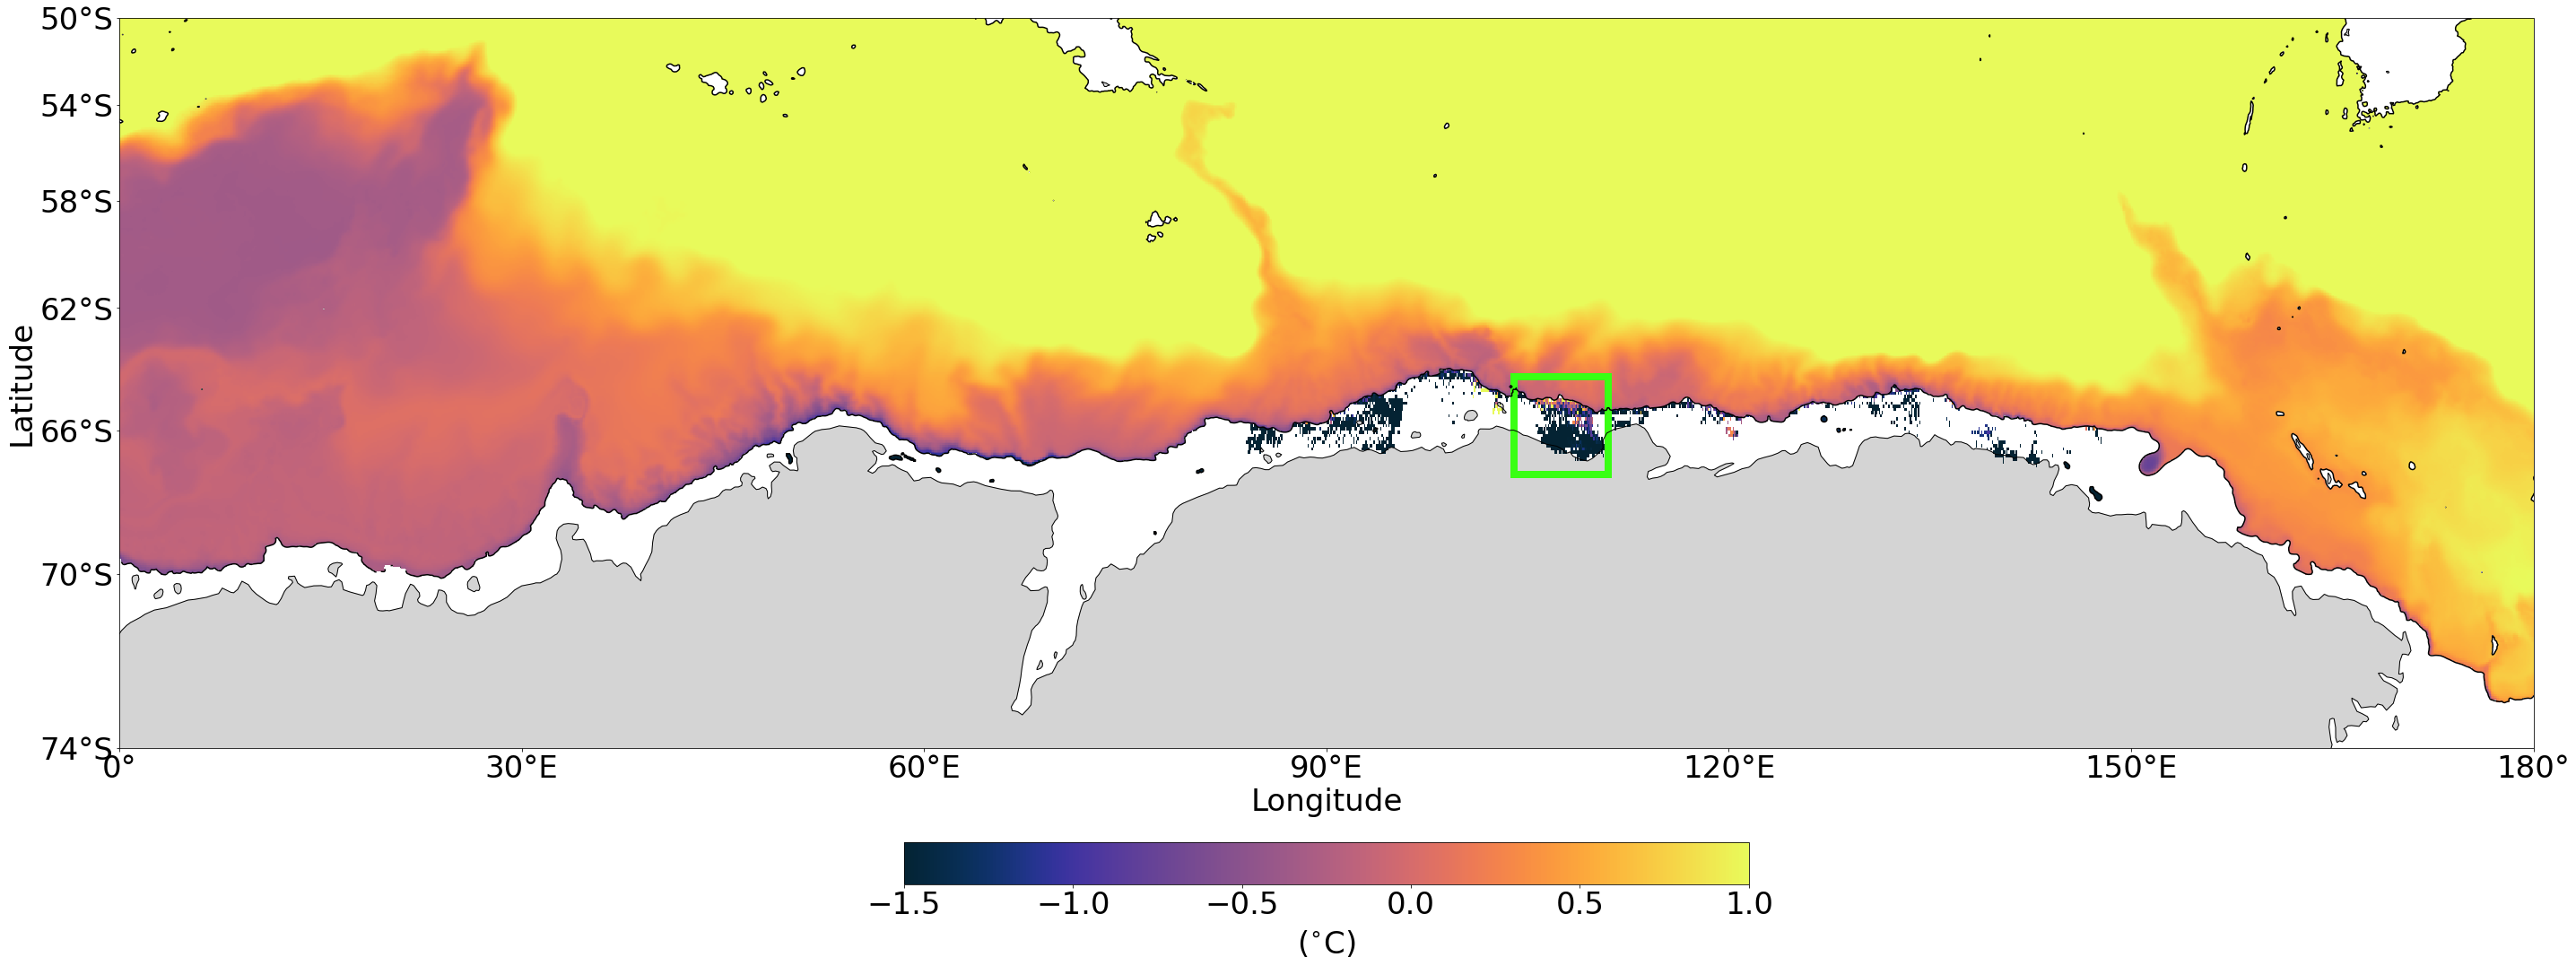

In [114]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(binned_meop_temp_renamed.xt_ocean,binned_meop_temp_renamed.yt_ocean,
                        binned_meop_temp_renamed, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
#cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
#cbar.ax.tick_params(labelsize=20)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add colorbar below the plot horizontally
cbar = fig.colorbar(pc, ax=ax, shrink=0.35, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize=fontsize, labelpad=10)
cbar.ax.tick_params(labelsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_horizontal_cbar_T400_obs.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

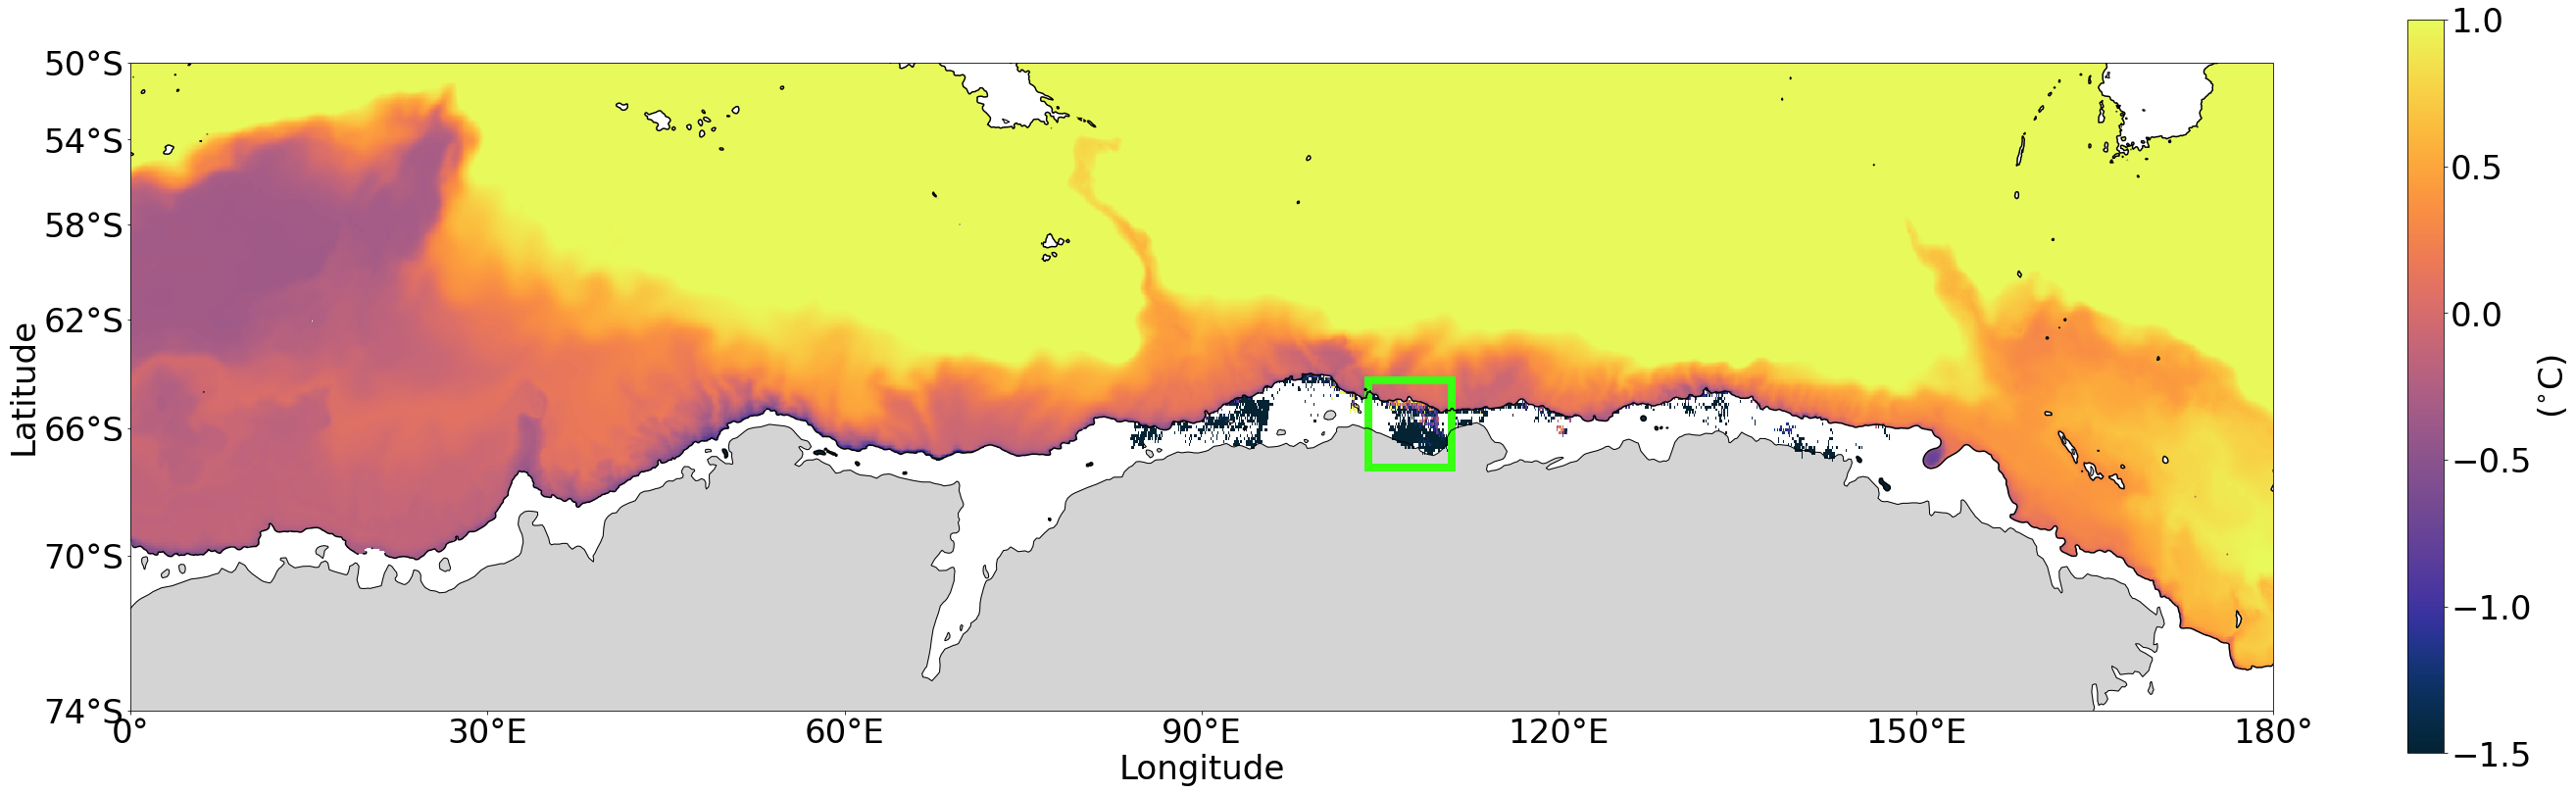

In [116]:
fontsize=34
fontsize2=36

# to create green box
import matplotlib.patches as mpatches 

projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-50)
fig=plt.figure(figsize=(40,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(binned_meop_temp_renamed.xt_ocean,binned_meop_temp_renamed.yt_ocean,
                        binned_meop_temp_renamed, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -70, -66, -62, -58, -54, -50], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=fontsize);
#plt.title('mCDW in East Antarctica',fontsize=fontsize2)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
#colourbar vertically
cbar=plt.colorbar(pc,shrink=0.35,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($^{\circ}$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# Add the green box
rect = mpatches.Rectangle(xy=[-256, -67.3], width=7, height=3,
                          edgecolor='#39FF14', facecolor='none',
                          linewidth=8,
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_mCDW_vertical_cbar_T400_obs.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')